In [1]:
import pandas as pd
import numpy as np
from scipy.special import factorial
import torch as pt
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
import ujson as js
import mysql.connector as mdb

pt.set_default_tensor_type('torch.FloatTensor')
#pt.set_default_tensor_type('torch.cuda.FloatTensor')
pd.set_option('display.max_rows', 2000)

In [2]:
def calc_grads(loss, coefs):
    coef_names = []
    coef_vals = []
    for coef_name, coef_val in coefs.items():
        coef_names.append(coef_name)
        coef_vals.append(coef_val)

    new_grad = pt.autograd.grad(loss, coef_vals, retain_graph = True)

    gradients = {}
    for coef_name, coef_grad in zip(coef_names, new_grad):
        gradients[coef_name] = coef_grad

    return gradients

In [3]:
with open('conn_params.json') as file:
    conn_params = js.load(file)

In [4]:
conn = mdb.connect(**conn_params)

In [5]:
sql_code = """
SELECT MarketRecord.record_date,
	MarketRecord.type_id,
	Types.type_name,
	MarketRecord.region_id,
	MapRegions.region_name,
	MarketRecord.order_count,
	MarketRecord.volume,
	MarketRecord.low_price,
	MarketRecord.avg_price,
	MarketRecord.high_price
FROM MarketRecord
JOIN Types
	ON MarketRecord.type_id = Types.type_id
JOIN MapRegions
	ON MarketRecord.region_id = MapRegions.region_id
WHERE MarketRecord.type_id IN (%s)
	AND MarketRecord.region_id IN (%s)
;"""

In [6]:
dataset = pd.read_sql(
    sql_code % (
        ','.join([str(x) for x in [34,35,36,37,38,39,40]]),
        10000002
    ),
    conn
)
conn.close()
dataset['record_date'] = pd.to_datetime(dataset['record_date'])

In [7]:
group_cols = ['type_name']
idx_col = 'record_date'
data_cols = ['volume', 'avg_price']

root_data = pd.DataFrame(
    index = pd.date_range(
        dataset[idx_col].min(),
        dataset[idx_col].max()
    )
)
working_data = root_data.copy()

In [8]:
for group, data in dataset.groupby(group_cols):
    group = group if type(group) is tuple else (group,)
    for data_col in data_cols:
        data_item = root_data.join(
            data.set_index(idx_col)[data_col],
            how = 'left'
        )
        working_data.insert(
            len(working_data.columns),
            '%s|%s' % (
                '_'.join([str(x) for x in group]),
                data_col
            ),
            data_item
        )

In [9]:
working_data[[
    col for col in working_data.columns if col.endswith('|avg_price')
]] = working_data[[
    col for col in working_data.columns if col.endswith('|avg_price')
]].fillna(method = 'ffill').fillna(method = 'bfill')
working_data[[
    col for col in working_data.columns if col.endswith('|volume')
]] = working_data[[
    col for col in working_data.columns if col.endswith('|volume')
]].fillna(0)

In [10]:
derivs = 2
horizon = 7

data_tensor = pt.from_numpy(working_data[[col for col in working_data.columns if col.endswith('|avg_price')]].values).type(pt.Tensor)
coefs = {
    'state': pt.zeros(derivs+1,data_tensor.shape[1])
}

learn_rate = 1e-0
alpha = 0.2
beta = 0.1
grad = {}
grad_sq = {}
clamp = 1e-16

loss_rcd = []

In [11]:
t = tqdm.tnrange(250)
for e in t:
    for value in coefs.values(): value.requires_grad = True
    coefs_proc = {}
    for key, value in coefs.items():
        if key in ('state',):
            coefs_proc[key] = pt.sigmoid(value)
        else:
            coefs_proc[key] = value

    state = [pt.stack([data_tensor[0,:], *([pt.zeros(data_tensor.shape[1])] * (derivs))], dim=0)]
    state_actual = [pt.stack([data_tensor[0,:], *([pt.zeros(data_tensor.shape[1])] * (derivs))], dim=0)]
    updater = np.stack([1 / factorial(i) for i in range(derivs+1)])
    updater = pt.from_numpy(np.stack([
        updater,
        *[
            np.pad(updater[:-j], (j,0), 'constant', constant_values = 0)
            for j in range(1,derivs+1)
        ]
    ], axis = 0)).type(pt.Tensor)
    
    for new_vals in data_tensor[1:,:]:
        predict_state = updater @ state[-1]
        new_state = [(
            coefs_proc['state'][0,:] * new_vals
        ) + (
            (1-coefs_proc['state'][0,:]) * predict_state[0,:]
        )]
        for d in range(1,derivs+1):
            new_state.append((
                    coefs_proc['state'][d,:] * (new_state[-1] - state[-1][d-1,:])
                ) + (
                    (1-coefs_proc['state'][d,:]) * predict_state[d,:]
            ))
        new_state = pt.stack(new_state, dim=0)
        state.append(new_state)
    state = pt.stack(state, dim=0)
    
    errors = []
    predictor = state.clone()
    for h in range(1,horizon+1):
        predictor = updater @ predictor
        predict = pt.clamp(predictor[:-h,0,:],0.01,np.inf)
        actual = data_tensor[h:,:]
        error = pt.sqrt((pt.log(predict / actual)**2).mean(dim=0))
        errors.append(error)
    errors = pt.stack(errors,dim=0)
    loss = pt.log(errors).mean()
    loss_rcd.append(loss.detach().cpu().numpy())
    t.set_postfix({'loss': loss_rcd[-1]})

    gradient = calc_grads(loss, coefs)

    with pt.no_grad():
        for key, value in gradient.items():
            grad[key] = (alpha * value) + ((1-alpha) * grad.get(key, value))
            grad_sq[key] = (beta * (value**2)) + ((1-beta) * grad_sq.get(key, value**2))
            learn_step = grad[key] / pt.clamp(pt.sqrt(grad_sq[key]), clamp, np.inf)
            coefs[key] = coefs[key] - (learn_step * learn_rate / (derivs+1))

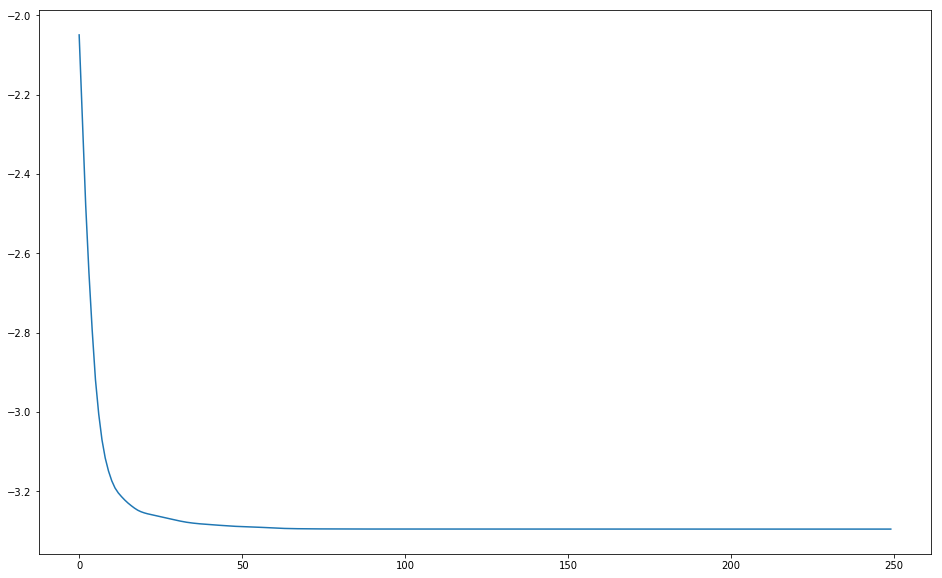

In [12]:
plt.figure(figsize=(16,10))
plt.plot(loss_rcd)

In [13]:
pd.DataFrame(
    errors.detach().cpu().numpy(),
    columns = [
        col.replace('|avg_price', '')
        for col in working_data.columns
        if col.endswith('|avg_price')
    ]
)

,Isogen,Megacyte,Mexallon,Nocxium,Pyerite,Tritanium,Zydrine
0,0.024571,0.035023,0.020576,0.025216,0.024655,0.020616,0.025753
1,0.031076,0.041073,0.026139,0.031217,0.030125,0.026120,0.032501
2,0.036062,0.047863,0.030231,0.036437,0.033444,0.029458,0.037139
3,0.039993,0.052508,0.033608,0.040443,0.035852,0.032069,0.041207
4,0.043273,0.057008,0.036570,0.043984,0.038063,0.034288,0.045117
5,0.046437,0.060641,0.039259,0.046920,0.039869,0.037015,0.048952
6,0.049195,0.064214,0.042104,0.049609,0.041581,0.039339,0.052462


In [14]:
pd.DataFrame(
    pt.sigmoid(coefs['state']).detach().cpu().numpy(),
    columns = [
        col.replace('|avg_price', '')
        for col in working_data.columns
        if col.endswith('|avg_price')
    ]
)

,Isogen,Megacyte,Mexallon,Nocxium,Pyerite,Tritanium,Zydrine
0,0.687437,0.656199,7.289594e-01,0.670089,0.482910,6.580094e-01,0.736704
1,0.001357,0.000319,3.951238e-08,0.001164,0.002185,7.050846e-08,0.000002
2,0.012138,0.000005,6.345614e-04,0.007746,0.008313,4.863031e-04,0.000139


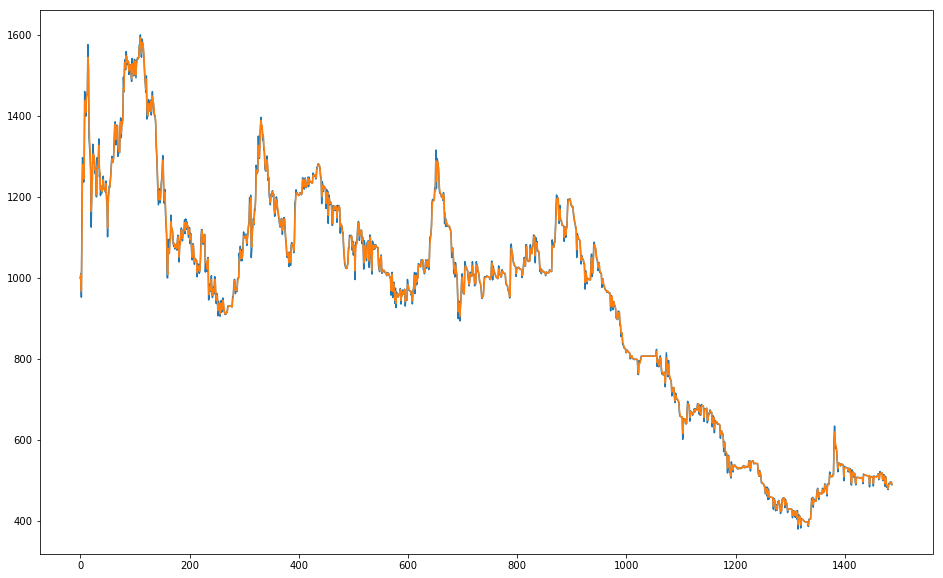

In [15]:
idx = 6
plt.figure(figsize=(16,10))
plt.plot(data_tensor[:,idx].detach().cpu().numpy())
plt.plot(state[:,0,idx].detach().cpu().numpy())